# Basic MLP

In [9]:
import numpy as np

In [10]:
class node: 
    def __init__(self, which, childnodes) -> None:
        self.theta = np.random.random(3)
        if which =='sigmoid':
            self.activation_function = sigmoid
            self.activation_function_derivative = sigmoid_derivative
        elif which == 'relu':
            self.activation_function = relu
            self.activation_function_derivative = relu_derivative
            
        
        self.childnodes = childnodes
        self.parentnodes = []  # for backpropagation
        self.weight_gradient = np.zeros(len(self.theta))
        self.z = 0
        self.return_saved = False
        


    def activation(self):
        if self.return_saved:
            return self.z
        # store childactivations for backpropagation
        self.childactivations = np.array([node.activation() for node in self.childnodes])
        self.a = self._preactivation(self.theta, self.childactivations)
        self.z = self.activation_function(self.a)
        # print('a',self.a, 'z',self.z)
        self.return_saved = True
        return self.z

    def _preactivation(self, theta, x):
        return theta @ x

    def backpropagation_calc_error_and_weight_gradient(self):
        # compute error gradient
        self.error_gradient = 0
        for i,parentnode in enumerate(self.parentnodes):
            if parentnode.__class__.__name__ != 'node':  # last layer, where loss is 2(ypred-y)
                self.error_gradient+=parentnode 
            else:
                self.error_gradient+=parentnode.error_gradient *  parentnode.activation_function_derivative(parentnode.z) *  parentnode.get_theta(self)             

        # compute weight gradient part of x(i)
        for j in range(len(self.theta)):
            self.weight_gradient[j] += self.error_gradient * self.activation_function_derivative(self.z) * self.childnodes[j].z
    
    def backpropagation_weight_update(self, alpha):
        # print('error_gradient',self.error_gradient)
        # compute new weights
        for j in range(len(self.theta)):
            self.theta[j] = self.theta[j] -alpha * self.weight_gradient[j]

    def get_theta(self, childnode):
        for i, cn in enumerate(self.childnodes):
            if cn == childnode:
                return self.theta[i]
    
    def undo_return_saved(self):
        self.return_saved = False
        for node in self.childnodes:
            if node.__class__.__name__ == 'node':
                node.undo_return_saved()
    
    def reset_weight_gradient(self):
        self.weight_gradient = np.zeros(len(self.theta))
                
class value:
    def __init__(self,value) -> None:
      self.z = value
    
    def activation(self):
        return self.z



def sigmoid(a):
    return 1/(1+np.e**(-a))

def sigmoid_derivative(a):
    return a*(1-a)

def relu(a):
    return max(0,a)

def relu_derivative(a):
    return int(a>0)



### Structure

In [11]:
# hypothesis(node03)
#         /|\    
# bias02 node12 node22  
#         /|\    //|  
# bias01 node11 node21  
#         /|\    //|  
# bias00   x0     x1    

In [12]:
# input
bias00 = value(1)
x0 = value(0)
x1 = value(0)

# first hidden layer
bias01 = value(1)
node11 = node('sigmoid', childnodes=[bias00, x0, x1])
node21 = node('sigmoid', childnodes=[bias00, x0, x1])

# second hidden layer
bias02 = value(1)
node12 = node('sigmoid', childnodes=[bias01, node11, node21])
node22 = node('sigmoid', childnodes=[bias01, node11, node21])

# link back backpropagation
node11.parentnodes = [node12, node22]
node21.parentnodes = [node12, node22]
# output
node03 = node('sigmoid', childnodes=[bias02, node12, node22])
# node13 = node('sigmoid', childnodes=[bias02, node12, node22])

# link back for backpropagation
node12.parentnodes = [node03]
node22.parentnodes = [node03]

def hypothesis(x):
    x0.z = x[0]
    x1.z = x[1]
    
    y0 = node03.activation()
    # y1 = node13.activation(compute_state)

    
    
    # node13.change_compute_state(compute_state)
    # print(y0)
    node03.undo_return_saved()
    return [y0]


# probably should have used this from the start ->
layers = [[node03],[node12,node22], [node11, node21]]

def backpropagation_calc_error_and_weight_gradient(y, alpha):
    loss_derivative(node03.z, y)
    node03.parentnodes = [loss_derivative(node03.z, y)]
    
    for layer in layers:
        for node in layer:
            node.backpropagation_calc_error_and_weight_gradient()

def backpropagation_weight_update(alpha):
    for layer in layers:
        for node in layer:
            node.backpropagation_weight_update(alpha=alpha)
            node.reset_weight_gradient()
    

def backpropagation_step(X, y, alpha):
    for i in range(len(y)):
        hypothesis(X[i])
        backpropagation_calc_error_and_weight_gradient(y[i], alpha)
        
    backpropagation_weight_update(alpha)


def loss_derivative(ypred, y):
    return 2*(ypred-y)
    


In [13]:
for layer in layers:
    print('layer')
    for node in layer:
        print(node.theta)

layer
[0.16860276 0.08756674 0.94428745]
layer
[0.82938616 0.56105725 0.35315517]
[0.8487849  0.66155148 0.50702616]
layer
[0.93935078 0.53625052 0.09319854]
[0.33771206 0.86816164 0.27276655]


## Test XOR


### Forward Phase

In [14]:
X = np.array([[0,0], 
              [0,1],
              [1,0],
              [1,1]])
y = np.array([0,1,1,0])

In [15]:
hypothesis(X[0])

[0.736472051479144]

### Backward phase

#### Stochastic (1 sample)

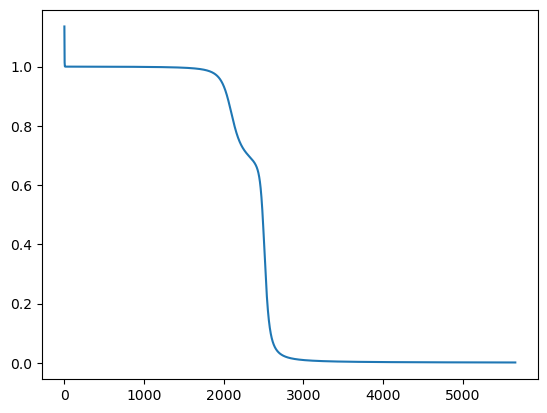

In [16]:
import matplotlib.pyplot as plt
errors = []

for _ in range(100000):
    idx = np.random.randint(0,len(y))
    # hypothesis(X[idx])
    # backpropagation(y[idx], alpha=0.05)
    backpropagation_step(X, y, alpha=0.3)
    error = sum((hypothesis(X[i])[0]-y[i])**2 for i in range(len(y)))
    errors.append(error)
    # print(error)
    if error<0.001:
        break

plt.plot(np.arange(len(errors)),errors)

In [17]:
for i in range(len(y)):
    print(f'X: {X[i]}')
    print(f'y: {y[i]} \ny_pred: {hypothesis(X[i])[0]}\n')


X: [0 0]
y: 0 
y_pred: 0.015808243713702194

X: [0 1]
y: 1 
y_pred: 0.9848052640373112

X: [1 0]
y: 1 
y_pred: 0.9848297401421993

X: [1 1]
y: 0 
y_pred: 0.016995077474333313

